=== Example 1: Uniform Prior ===
Prior mean: 0.500
Prior variance: 0.083

Posterior parameters: a=2.0, b=7.0
Posterior mean: 0.222
Posterior mode: 0.143
Posterior variance: 0.0173
95% Credible interval: [0.032, 0.527]

MLE estimate: 0.143

=== Example 2: Informative Prior ===
Prior mean: 0.333
Posterior parameters: a=12.0, b=13.0
Posterior mean: 0.480

=== Example 3: Posterior Predictive ===
Probability of 0 successes in next 5 trials: 0.013
Probability of 1 success in next 5 trials: 0.064
Expected successes in next 5 trials: 3.333

=== Example 4: Model Evidence ===
Model evidence p(y=7|n=10): 0.090909


C:\Users\Petrb\AppData\Local\Temp\ipykernel_16492\3188778981.py:178: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  likelihood_norm = likelihood / np.trapz(likelihood, theta_range)


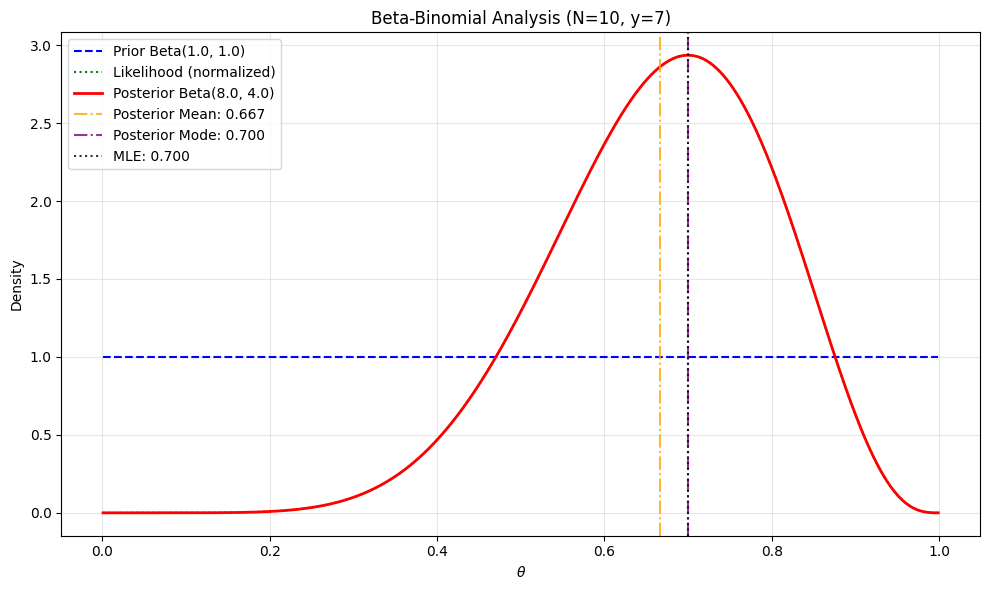


=== Example 5: Sequential Updating ===
Sequential data arrival:
After batch 1: n=5, y=2 → Beta(3.0, 4.0), mean=0.429
After batch 2: n=3, y=1 → Beta(4.0, 6.0), mean=0.400
After batch 3: n=4, y=3 → Beta(7.0, 7.0), mean=0.500

All data at once: Beta(7.0, 7.0)

=== Example 6: Prior Comparison ===
Uniform prior: mean=0.500, 95% CI=[0.094, 0.906]
Jeffreys prior: mean=0.500, 95% CI=[0.061, 0.939]
Skeptical prior: mean=0.154, 95% CI=[0.021, 0.385]
Optimistic prior: mean=0.846, 95% CI=[0.615, 0.979]

=== Example 7: Hand Calculation ===
Hand calculation for N=7, y=1 with uniform prior (a₀=1, b₀=1):
Posterior parameters: a = 1 + 1 = 2, b = 1 + 7 - 1 = 7
Posterior mean: 2/(2+7) = 0.2222
Posterior mode: (2-1)/(2+7-2) = 0.1429
MLE: 1/7 = 0.1429

Code verification:
Posterior mean: 0.2222
Posterior mode: 0.1429

=== Example 8: JAX Gradient Computation ===
Gradient of negative log-likelihood at θ=0.3: 5.2381
Gradient at MLE (θ=0.1429): 0.0000 (should be close to 0)


In [2]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, grad
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

# Define JIT-compiled functions outside the class
@jit
def beta_pdf_jax(theta, a, b):
    """Beta probability density function using JAX"""
    log_pdf = (a - 1) * jnp.log(theta) + (b - 1) * jnp.log(1 - theta)
    # Normalize using Beta function
    log_norm = jax.scipy.special.gammaln(a) + jax.scipy.special.gammaln(b) - jax.scipy.special.gammaln(a + b)
    return jnp.exp(log_pdf - log_norm)

@jit
def binomial_pmf_jax(y, n, theta):
    """Binomial probability mass function using JAX"""
    log_coef = jax.scipy.special.gammaln(n + 1) - jax.scipy.special.gammaln(y + 1) - jax.scipy.special.gammaln(n - y + 1)
    log_pmf = log_coef + y * jnp.log(theta) + (n - y) * jnp.log(1 - theta)
    return jnp.exp(log_pmf)

@jit
def model_evidence_jax(n, y, a0, b0):
    """Compute model evidence (marginal likelihood) analytically using JAX"""
    # Using log-space for numerical stability
    log_binom = jax.scipy.special.gammaln(n + 1) - jax.scipy.special.gammaln(y + 1) - jax.scipy.special.gammaln(n - y + 1)
    
    # Beta function in log space
    log_beta_num = (jax.scipy.special.gammaln(y + a0) + 
                   jax.scipy.special.gammaln(n - y + b0) - 
                   jax.scipy.special.gammaln(n + a0 + b0))
    
    log_beta_denom = (jax.scipy.special.gammaln(a0) + 
                     jax.scipy.special.gammaln(b0) - 
                     jax.scipy.special.gammaln(a0 + b0))
    
    return jnp.exp(log_binom + log_beta_num - log_beta_denom)

class BetaBinomialModel:
    """Implementation of the Beta-Binomial model using JAX and SciPy"""
    
    def __init__(self, a0=1.0, b0=1.0):
        """
        Initialize the model with prior hyperparameters
        
        Args:
            a0: Alpha parameter of Beta prior (default: 1.0 for uniform prior)
            b0: Beta parameter of Beta prior (default: 1.0 for uniform prior)
        """
        self.a0 = a0
        self.b0 = b0
        
    def beta_pdf(self, theta, a, b):
        """Beta probability density function wrapper"""
        # Convert to JAX array and use the JIT-compiled function
        return np.array(beta_pdf_jax(jnp.array(theta), jnp.array(a), jnp.array(b)))
    
    def binomial_pmf(self, y, n, theta):
        """Binomial probability mass function wrapper"""
        # Convert to JAX array and use the JIT-compiled function
        return np.array(binomial_pmf_jax(jnp.array(y), jnp.array(n), jnp.array(theta)))
    
    def compute_posterior(self, n, y):
        """
        Compute posterior parameters analytically
        
        Args:
            n: Number of trials
            y: Number of successes
            
        Returns:
            Tuple (a_posterior, b_posterior)
        """
        a_post = self.a0 + y
        b_post = self.b0 + n - y
        return a_post, b_post
    
    def posterior_mean(self, n, y):
        """Compute posterior mean (expected value)"""
        a_post, b_post = self.compute_posterior(n, y)
        return a_post / (a_post + b_post)
    
    def posterior_mode(self, n, y):
        """Compute posterior mode (MAP estimate)"""
        a_post, b_post = self.compute_posterior(n, y)
        if a_post > 1 and b_post > 1:
            return (a_post - 1) / (a_post + b_post - 2)
        else:
            # Mode is at boundary
            if a_post <= 1 and b_post > 1:
                return 0.0
            elif a_post > 1 and b_post <= 1:
                return 1.0
            else:
                # Uniform or bimodal - return mean
                return self.posterior_mean(n, y)
    
    def posterior_variance(self, n, y):
        """Compute posterior variance"""
        a_post, b_post = self.compute_posterior(n, y)
        numerator = a_post * b_post
        denominator = (a_post + b_post)**2 * (a_post + b_post + 1)
        return numerator / denominator
    
    def credible_interval(self, n, y, alpha=0.05):
        """
        Compute credible interval using SciPy
        
        Args:
            n: Number of trials
            y: Number of successes
            alpha: Significance level (default: 0.05 for 95% CI)
            
        Returns:
            Tuple (lower, upper) bounds of credible interval
        """
        a_post, b_post = self.compute_posterior(n, y)
        dist = stats.beta(a_post, b_post)
        return dist.ppf(alpha/2), dist.ppf(1 - alpha/2)
    
    def posterior_predictive(self, n_new, n_obs, y_obs):
        """
        Compute posterior predictive distribution
        
        Args:
            n_new: Number of new trials
            n_obs: Number of observed trials
            y_obs: Number of observed successes
            
        Returns:
            Beta-Binomial distribution object from SciPy
        """
        a_post, b_post = self.compute_posterior(n_obs, y_obs)
        # Return Beta-Binomial distribution
        return stats.betabinom(n_new, a_post, b_post)
    
    def model_evidence(self, n, y):
        """
        Compute model evidence (marginal likelihood) analytically
        
        Args:
            n: Number of trials
            y: Number of successes
            
        Returns:
            p(y) - the marginal likelihood
        """
        return np.array(model_evidence_jax(jnp.array(n), jnp.array(y), 
                                          jnp.array(self.a0), jnp.array(self.b0)))
    
    def plot_analysis(self, n, y, n_points=1000):
        """
        Plot prior, likelihood, and posterior distributions
        
        Args:
            n: Number of trials
            y: Number of successes
            n_points: Number of points for plotting
        """
        theta_range = np.linspace(0.001, 0.999, n_points)
        
        # Compute distributions using vectorized operations
        # Use SciPy for plotting (more convenient than JAX for this purpose)
        prior_dist = stats.beta(self.a0, self.b0)
        prior = prior_dist.pdf(theta_range)
        
        # Compute likelihood for each theta
        likelihood = np.array([stats.binom.pmf(y, n, t) for t in theta_range])
        
        # Posterior
        a_post, b_post = self.compute_posterior(n, y)
        posterior_dist = stats.beta(a_post, b_post)
        posterior = posterior_dist.pdf(theta_range)
        
        # Normalize likelihood for visualization
        likelihood_norm = likelihood / np.trapz(likelihood, theta_range)
        
        # Plot
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(theta_range, prior, 'b--', label=f'Prior Beta({self.a0}, {self.b0})')
        ax.plot(theta_range, likelihood_norm, 'g:', label=f'Likelihood (normalized)')
        ax.plot(theta_range, posterior, 'r-', linewidth=2, 
                label=f'Posterior Beta({a_post}, {b_post})')
        
        # Add vertical lines for estimates
        post_mean = self.posterior_mean(n, y)
        post_mode = self.posterior_mode(n, y)
        mle = y / n
        
        ax.axvline(post_mean, color='orange', linestyle='-.', alpha=0.8,
                  label=f'Posterior Mean: {post_mean:.3f}')
        ax.axvline(post_mode, color='purple', linestyle='-.', alpha=0.8,
                  label=f'Posterior Mode: {post_mode:.3f}')
        ax.axvline(mle, color='black', linestyle=':', alpha=0.8,
                  label=f'MLE: {mle:.3f}')
        
        ax.set_xlabel(r'$\theta$')
        ax.set_ylabel('Density')
        ax.set_title(f'Beta-Binomial Analysis (N={n}, y={y})')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        return fig, ax

# Example 1: Basic usage with uniform prior
print("=== Example 1: Uniform Prior ===")
model = BetaBinomialModel(a0=1.0, b0=1.0)
n, y = 7, 1

# Prior analysis
print(f"Prior mean: {1/(1+1):.3f}")
print(f"Prior variance: {(1*1)/((1+1)**2*(1+1+1)):.3f}")

# Posterior analysis
a_post, b_post = model.compute_posterior(n, y)
print(f"\nPosterior parameters: a={a_post}, b={b_post}")
print(f"Posterior mean: {model.posterior_mean(n, y):.3f}")
print(f"Posterior mode: {model.posterior_mode(n, y):.3f}")
print(f"Posterior variance: {model.posterior_variance(n, y):.4f}")

# Credible interval
lower, upper = model.credible_interval(n, y)
print(f"95% Credible interval: [{lower:.3f}, {upper:.3f}]")

# MLE for comparison
mle = y / n
print(f"\nMLE estimate: {mle:.3f}")

# Example 2: Informative prior
print("\n=== Example 2: Informative Prior ===")
model2 = BetaBinomialModel(a0=5.0, b0=10.0)  # Prior belief: θ ≈ 0.33
n, y = 10, 7

print(f"Prior mean: {5/(5+10):.3f}")
a_post2, b_post2 = model2.compute_posterior(n, y)
print(f"Posterior parameters: a={a_post2}, b={b_post2}")
print(f"Posterior mean: {model2.posterior_mean(n, y):.3f}")

# Example 3: Posterior predictive
print("\n=== Example 3: Posterior Predictive ===")
n_new = 5
pred_dist = model.posterior_predictive(n_new, n, y)
print(f"Probability of 0 successes in next {n_new} trials: {pred_dist.pmf(0):.3f}")
print(f"Probability of 1 success in next {n_new} trials: {pred_dist.pmf(1):.3f}")
print(f"Expected successes in next {n_new} trials: {pred_dist.mean():.3f}")

# Example 4: Model evidence
print("\n=== Example 4: Model Evidence ===")
evidence = model.model_evidence(n, y)
print(f"Model evidence p(y={y}|n={n}): {evidence:.6f}")

# Plot visualization
fig, ax = model.plot_analysis(n, y)
plt.tight_layout()
plt.show()

# Example 5: Sequential updating
print("\n=== Example 5: Sequential Updating ===")
model_seq = BetaBinomialModel(a0=1.0, b0=1.0)
data_sequence = [(5, 2), (3, 1), (4, 3)]  # (n, y) pairs

print("Sequential data arrival:")
a_current, b_current = model_seq.a0, model_seq.b0
for i, (n_i, y_i) in enumerate(data_sequence, 1):
    # Update with new data
    a_current += y_i
    b_current += n_i - y_i
    mean = a_current / (a_current + b_current)
    print(f"After batch {i}: n={n_i}, y={y_i} → Beta({a_current}, {b_current}), mean={mean:.3f}")

# Verify this equals processing all data at once
n_total = sum(d[0] for d in data_sequence)
y_total = sum(d[1] for d in data_sequence)
a_final, b_final = model_seq.compute_posterior(n_total, y_total)
print(f"\nAll data at once: Beta({a_final}, {b_final})")

# Example 6: Comparison of priors
print("\n=== Example 6: Prior Comparison ===")
n, y = 2, 1  # Small sample size
priors = [
    ("Uniform", 1.0, 1.0),
    ("Jeffreys", 0.5, 0.5),
    ("Skeptical", 1.0, 10.0),
    ("Optimistic", 10.0, 1.0)
]

for name, a0, b0 in priors:
    model_comp = BetaBinomialModel(a0, b0)
    mean = model_comp.posterior_mean(n, y)
    ci = model_comp.credible_interval(n, y)
    print(f"{name} prior: mean={mean:.3f}, 95% CI=[{ci[0]:.3f}, {ci[1]:.3f}]")

# Example 7: Hand calculation verification
print("\n=== Example 7: Hand Calculation ===")
# Using the text's example: N=7, y=1 with uniform prior
print("Hand calculation for N=7, y=1 with uniform prior (a₀=1, b₀=1):")
print(f"Posterior parameters: a = 1 + 1 = 2, b = 1 + 7 - 1 = 7")
print(f"Posterior mean: 2/(2+7) = {2/9:.4f}")
print(f"Posterior mode: (2-1)/(2+7-2) = {1/7:.4f}")
print(f"MLE: 1/7 = {1/7:.4f}")

# Verify with implementation
model_verify = BetaBinomialModel(1.0, 1.0)
print(f"\nCode verification:")
print(f"Posterior mean: {model_verify.posterior_mean(7, 1):.4f}")
print(f"Posterior mode: {model_verify.posterior_mode(7, 1):.4f}")

# Example 8: JAX demonstration - Computing gradients
print("\n=== Example 8: JAX Gradient Computation ===")
# Define a loss function for finding the MLE using gradient descent
@jit
def neg_log_likelihood(theta, n, y):
    """Negative log-likelihood for gradient-based optimization"""
    # Add small epsilon to avoid log(0)
    eps = 1e-10
    theta_clipped = jnp.clip(theta, eps, 1-eps)
    return -(y * jnp.log(theta_clipped) + (n - y) * jnp.log(1 - theta_clipped))

# Compute gradient
grad_nll = grad(neg_log_likelihood)

# Example: gradient at different theta values
theta_test = 0.3
gradient = grad_nll(theta_test, jnp.array(7.0), jnp.array(1.0))
print(f"Gradient of negative log-likelihood at θ={theta_test}: {gradient:.4f}")

# Verify that gradient is 0 at MLE
mle_estimate = 1/7
gradient_at_mle = grad_nll(mle_estimate, jnp.array(7.0), jnp.array(1.0))
print(f"Gradient at MLE (θ={mle_estimate:.4f}): {gradient_at_mle:.4f} (should be close to 0)")

=== 1. Hierarchical Beta-Binomial Model ===
True parameters: a=3.0, b=7.0
MAP estimates: a=4.048, b=8.011
Implied mean: 0.336
True mean: 0.300

=== 2. Beta-Binomial Regression ===
True beta: [-0.5  0.8 -0.4]
Estimated beta: [0. 0. 0.]
True phi: 10.0
Estimated phi: 10.000

=== 3. Mixture of Beta-Binomials ===
True mixture parameters:
  Component 1: π=0.3, α=1.0, β=8.0
  Component 2: π=0.7, α=5.0, β=2.0

Estimated mixture parameters:
  Component 1: π=0.210, α=0.243, β=0.842
  Component 2: π=0.790, α=2.165, β=1.088

Converged: False


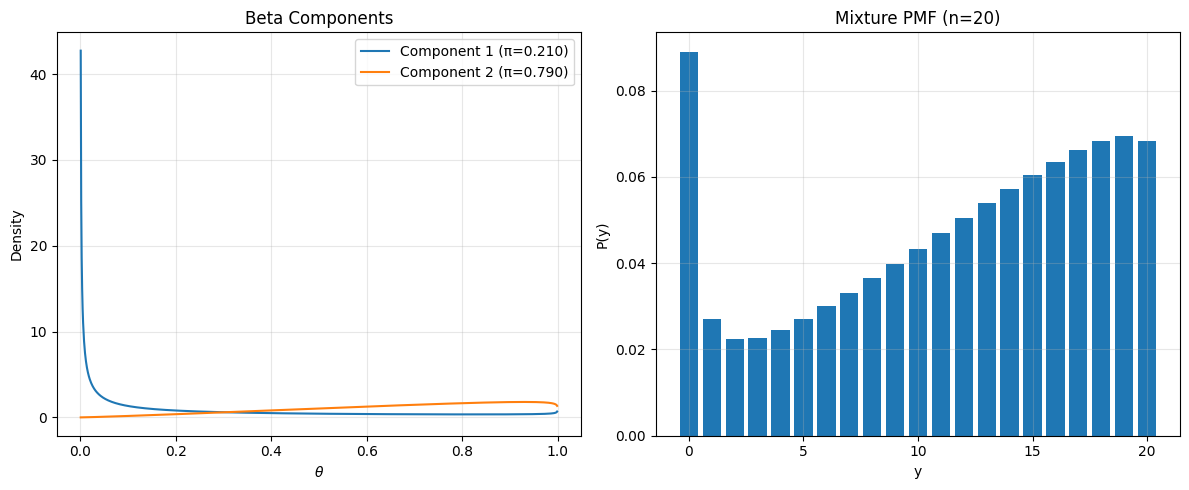

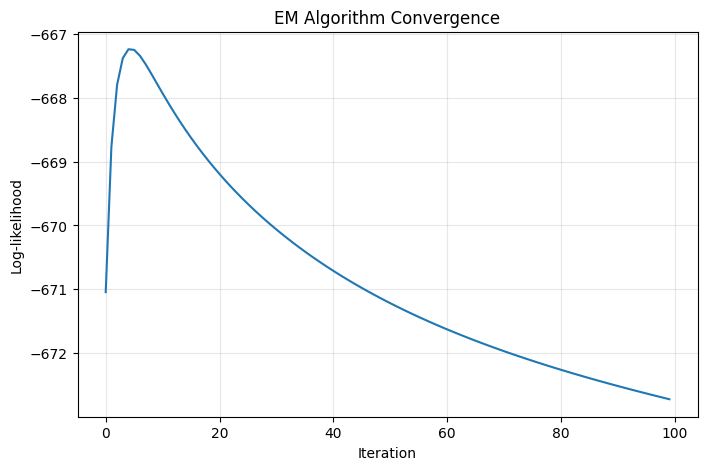

In [6]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, grad
import jax.scipy.stats as jstats
import scipy.stats as stats
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional

# Hierarchical Beta-Binomial Model with Hyperpriors
class HierarchicalBetaBinomial:
    """
    Hierarchical Beta-Binomial model where the parameters a and b 
    themselves have prior distributions:
    - a ~ Gamma(α_a, β_a)
    - b ~ Gamma(α_b, β_b)
    - θ_i ~ Beta(a, b) for each group i
    - y_i ~ Binomial(n_i, θ_i)
    """
    
    def __init__(self, alpha_a=2.0, beta_a=1.0, alpha_b=2.0, beta_b=1.0):
        """Initialize hyperprior parameters"""
        self.alpha_a = alpha_a
        self.beta_a = beta_a
        self.alpha_b = alpha_b
        self.beta_b = beta_b
        
    def log_likelihood(self, a, b, n_array, y_array):
        """
        Compute log-likelihood for multiple groups
        Using the marginal likelihood after integrating out θ
        """
        log_lik = 0
        for n, y in zip(n_array, y_array):
            # Log Beta-Binomial likelihood
            log_lik += (jax.scipy.special.gammaln(n + 1) - 
                       jax.scipy.special.gammaln(y + 1) - 
                       jax.scipy.special.gammaln(n - y + 1) +
                       jax.scipy.special.gammaln(y + a) + 
                       jax.scipy.special.gammaln(n - y + b) - 
                       jax.scipy.special.gammaln(n + a + b) +
                       jax.scipy.special.gammaln(a + b) - 
                       jax.scipy.special.gammaln(a) - 
                       jax.scipy.special.gammaln(b))
        return log_lik
    
    def log_prior(self, a, b):
        """Log prior for a and b"""
        # Gamma priors
        log_prior_a = jstats.gamma.logpdf(a, self.alpha_a, scale=1/self.beta_a)
        log_prior_b = jstats.gamma.logpdf(b, self.alpha_b, scale=1/self.beta_b)
        return log_prior_a + log_prior_b
    
    def log_posterior(self, a, b, n_array, y_array):
        """Log posterior = log likelihood + log prior"""
        return self.log_likelihood(a, b, n_array, y_array) + self.log_prior(a, b)
    
    def fit_map(self, n_array, y_array, init_params=None):
        """Find MAP estimates using optimization"""
        if init_params is None:
            # Initialize with method of moments
            p_hat = np.array(y_array) / np.array(n_array)
            mean_p = np.mean(p_hat)
            var_p = np.var(p_hat)
            
            # Method of moments for Beta distribution
            if var_p < mean_p * (1 - mean_p):
                common_param = mean_p * (1 - mean_p) / var_p - 1
                init_a = mean_p * common_param
                init_b = (1 - mean_p) * common_param
            else:
                init_a, init_b = 2.0, 2.0
                
            init_params = [init_a, init_b]
        
        # Convert to JAX arrays
        n_jax = jnp.array(n_array)
        y_jax = jnp.array(y_array)
        
        # Negative log posterior for minimization
        def neg_log_post(params):
            a, b = params
            if a <= 0 or b <= 0:
                return np.inf
            return -float(self.log_posterior(a, b, n_jax, y_jax))
        
        result = minimize(neg_log_post, init_params, method='L-BFGS-B',
                         bounds=[(0.01, 100), (0.01, 100)])
        
        return result.x
    
    def posterior_predictive(self, a, b, n_new):
        """Posterior predictive for new data"""
        return stats.betabinom(n_new, a, b)


# Define JIT-compiled functions for regression model
@jit
def inv_logit(x):
    """Inverse logit (sigmoid) function"""
    return 1 / (1 + jnp.exp(-x))

@jit
def beta_binomial_log_lik_single(y, n, a, b):
    """Single observation beta-binomial log-likelihood"""
    return (jax.scipy.special.gammaln(n + 1) - 
            jax.scipy.special.gammaln(y + 1) - 
            jax.scipy.special.gammaln(n - y + 1) +
            jax.scipy.special.gammaln(y + a) + 
            jax.scipy.special.gammaln(n - y + b) - 
            jax.scipy.special.gammaln(n + a + b) +
            jax.scipy.special.gammaln(a + b) - 
            jax.scipy.special.gammaln(a) - 
            jax.scipy.special.gammaln(b))

# Vectorized version
beta_binomial_log_lik_vec = vmap(beta_binomial_log_lik_single)

@jit
def regression_log_likelihood(beta, log_phi, X, n_array, y_array):
    """Compute log-likelihood for regression model"""
    phi = jnp.exp(log_phi)  # Ensure phi > 0
    
    # Compute means
    mu = inv_logit(X @ beta)
    
    # Convert to Beta parameters
    a = mu * phi
    b = (1 - mu) * phi
    
    # Compute log-likelihood for all observations
    log_liks = beta_binomial_log_lik_vec(y_array, n_array, a, b)
    return jnp.sum(log_liks)


# Beta-Binomial Regression Model
class BetaBinomialRegression:
    """
    Beta-Binomial regression where the parameters depend on covariates:
    - logit(μ_i) = X_i @ β
    - θ_i ~ Beta(μ_i * ϕ, (1 - μ_i) * ϕ)
    - y_i ~ Binomial(n_i, θ_i)
    
    where ϕ is a dispersion parameter and μ_i is the mean
    """
    
    def __init__(self):
        self.beta = None
        self.phi = None
    
    def fit(self, X, n_array, y_array):
        """Fit the model using maximum likelihood"""
        n_features = X.shape[1]
        
        # Initialize parameters
        init_beta = np.zeros(n_features)
        init_log_phi = np.log(10.0)  # Start with moderate dispersion
        init_params = np.concatenate([init_beta, [init_log_phi]])
        
        # Convert to JAX arrays
        X_jax = jnp.array(X)
        n_jax = jnp.array(n_array)
        y_jax = jnp.array(y_array)
        
        # Negative log-likelihood for optimization
        def neg_log_lik(params):
            beta = jnp.array(params[:-1])
            log_phi = jnp.array(params[-1])
            return -float(regression_log_likelihood(beta, log_phi, X_jax, n_jax, y_jax))
        
        result = minimize(neg_log_lik, init_params, method='L-BFGS-B')
        
        self.beta = result.x[:-1]
        self.phi = np.exp(result.x[-1])
        
        return self
    
    def predict(self, X_new):
        """Predict mean probability for new covariates"""
        mu = 1 / (1 + np.exp(-X_new @ self.beta))
        return mu
    
    def predict_distribution(self, X_new, n_new):
        """Predict full distribution for new data"""
        mu = self.predict(X_new)
        a = mu * self.phi
        b = (1 - mu) * self.phi
        return stats.betabinom(n_new, a, b)


# Mixture of Beta-Binomials Model
class MixtureBetaBinomial:
    """
    Mixture of K Beta-Binomial distributions:
    - π_k: mixing weights (sum to 1)
    - θ ~ Σ_k π_k * Beta(a_k, b_k)
    - y ~ Binomial(n, θ)
    
    Fitted using EM algorithm
    """
    
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.weights = None
        self.alphas = None
        self.betas = None
        self.converged = False
        
    def _initialize_params(self, n_array, y_array):
        """Initialize parameters using k-means on success rates"""
        p_hat = np.array(y_array) / np.array(n_array)
        
        # Simple initialization: split data into quantiles
        quantiles = np.linspace(0, 1, self.n_components + 1)[1:-1]
        thresholds = np.quantile(p_hat, quantiles)
        
        # Initialize parameters for each component
        self.weights = np.ones(self.n_components) / self.n_components
        self.alphas = np.zeros(self.n_components)
        self.betas = np.zeros(self.n_components)
        
        for k in range(self.n_components):
            if k == 0:
                mask = p_hat <= thresholds[0] if len(thresholds) > 0 else np.ones_like(p_hat, dtype=bool)
            elif k == self.n_components - 1:
                mask = p_hat > thresholds[-1] if len(thresholds) > 0 else np.ones_like(p_hat, dtype=bool)
            else:
                mask = (p_hat > thresholds[k-1]) & (p_hat <= thresholds[k])
            
            if np.sum(mask) > 0:
                component_p = p_hat[mask]
                mean_p = np.mean(component_p)
                var_p = np.var(component_p)
                
                # Method of moments
                if var_p > 0 and var_p < mean_p * (1 - mean_p):
                    common = mean_p * (1 - mean_p) / var_p - 1
                    self.alphas[k] = max(mean_p * common, 0.1)
                    self.betas[k] = max((1 - mean_p) * common, 0.1)
                else:
                    self.alphas[k] = max(mean_p * 10, 0.1)
                    self.betas[k] = max((1 - mean_p) * 10, 0.1)
            else:
                self.alphas[k] = 1.0
                self.betas[k] = 1.0
    
    def _e_step(self, n_array, y_array):
        """E-step: compute responsibilities"""
        n_samples = len(n_array)
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for i in range(n_samples):
            for k in range(self.n_components):
                # Compute Beta-Binomial probability
                prob = stats.betabinom.pmf(y_array[i], n_array[i], 
                                          self.alphas[k], self.betas[k])
                responsibilities[i, k] = self.weights[k] * prob
            
            # Normalize
            total = np.sum(responsibilities[i, :])
            if total > 0:
                responsibilities[i, :] /= total
            else:
                responsibilities[i, :] = 1.0 / self.n_components
                
        return responsibilities
    
    def _m_step(self, n_array, y_array, responsibilities):
        """M-step: update parameters"""
        n_samples = len(n_array)
        
        # Update weights
        self.weights = np.sum(responsibilities, axis=0) / n_samples
        
        # Update Beta parameters for each component
        for k in range(self.n_components):
            resp_k = responsibilities[:, k]
            
            if np.sum(resp_k) < 1e-10:
                continue
                
            # Weighted mean and variance
            p_hat = y_array / n_array
            weighted_mean = np.sum(resp_k * p_hat) / np.sum(resp_k)
            weighted_var = np.sum(resp_k * (p_hat - weighted_mean)**2) / np.sum(resp_k)
            
            # Method of moments update
            if weighted_var > 0 and weighted_var < weighted_mean * (1 - weighted_mean):
                common = weighted_mean * (1 - weighted_mean) / weighted_var - 1
                self.alphas[k] = max(weighted_mean * common, 0.1)
                self.betas[k] = max((1 - weighted_mean) * common, 0.1)
            else:
                self.alphas[k] = max(weighted_mean * 10, 0.1)
                self.betas[k] = max((1 - weighted_mean) * 10, 0.1)
    
    def fit(self, n_array, y_array, max_iter=100, tol=1e-6):
        """Fit the mixture model using EM algorithm"""
        n_array = np.array(n_array)
        y_array = np.array(y_array)
        
        # Initialize parameters
        self._initialize_params(n_array, y_array)
        
        log_likelihoods = []
        
        for iteration in range(max_iter):
            # E-step
            responsibilities = self._e_step(n_array, y_array)
            
            # M-step
            self._m_step(n_array, y_array, responsibilities)
            
            # Compute log-likelihood
            log_lik = self.log_likelihood(n_array, y_array)
            log_likelihoods.append(log_lik)
            
            # Check convergence
            if iteration > 0:
                if abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
                    self.converged = True
                    break
        
        return self, log_likelihoods
    
    def log_likelihood(self, n_array, y_array):
        """Compute total log-likelihood"""
        log_lik = 0
        
        for i in range(len(n_array)):
            # Compute mixture probability
            prob = 0
            for k in range(self.n_components):
                prob += self.weights[k] * stats.betabinom.pmf(
                    y_array[i], n_array[i], self.alphas[k], self.betas[k])
            
            log_lik += np.log(prob + 1e-10)
            
        return log_lik
    
    def predict_proba(self, n_array, y_array):
        """Predict component membership probabilities"""
        return self._e_step(n_array, y_array)
    
    def predict_distribution(self, n_new):
        """Predict distribution for new data"""
        pmf = np.zeros(n_new + 1)
        
        for k in range(self.n_components):
            component_pmf = stats.betabinom.pmf(
                np.arange(n_new + 1), n_new, self.alphas[k], self.betas[k])
            pmf += self.weights[k] * component_pmf
            
        return pmf
    
    def plot_components(self, n_plot=20):
        """Visualize the mixture components"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot component densities
        theta_range = np.linspace(0.001, 0.999, 1000)
        
        for k in range(self.n_components):
            density = stats.beta.pdf(theta_range, self.alphas[k], self.betas[k])
            ax1.plot(theta_range, density, 
                    label=f'Component {k+1} (π={self.weights[k]:.3f})')
        
        ax1.set_xlabel(r'$\theta$')
        ax1.set_ylabel('Density')
        ax1.set_title('Beta Components')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot mixture PMF
        y_range = np.arange(n_plot + 1)
        pmf = self.predict_distribution(n_plot)
        
        ax2.bar(y_range, pmf)
        ax2.set_xlabel('y')
        ax2.set_ylabel('P(y)')
        ax2.set_title(f'Mixture PMF (n={n_plot})')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

# Simple Beta-Binomial Model for comparison
class BetaBinomialModel:
    """Simple Beta-Binomial model for comparison"""
    def __init__(self):
        self.a = None
        self.b = None

# Example usage
if __name__ == "__main__":
    # Generate synthetic data for demonstrations
    np.random.seed(42)
    
    print("=== 1. Hierarchical Beta-Binomial Model ===")
    # Multiple groups with shared hyperparameters
    true_a, true_b = 3.0, 7.0
    n_groups = 5
    n_trials = [50, 40, 60, 55, 45]
    
    # Generate data
    true_thetas = np.random.beta(true_a, true_b, n_groups)
    y_obs = [np.random.binomial(n, theta) for n, theta in zip(n_trials, true_thetas)]
    
    # Fit hierarchical model
    hier_model = HierarchicalBetaBinomial()
    a_map, b_map = hier_model.fit_map(n_trials, y_obs)
    
    print(f"True parameters: a={true_a}, b={true_b}")
    print(f"MAP estimates: a={a_map:.3f}, b={b_map:.3f}")
    print(f"Implied mean: {a_map/(a_map+b_map):.3f}")
    print(f"True mean: {true_a/(true_a+true_b):.3f}")
    
    print("\n=== 2. Beta-Binomial Regression ===")
    # Generate regression data
    n_samples = 100
    X = np.column_stack([
        np.ones(n_samples),  # Intercept
        np.random.normal(0, 1, n_samples),  # Covariate 1
        np.random.normal(0, 1, n_samples)   # Covariate 2
    ])
    
    true_beta = np.array([-0.5, 0.8, -0.4])
    true_phi = 10.0
    
    # Generate outcomes
    mu = 1 / (1 + np.exp(-X @ true_beta))
    n_trials_reg = np.random.randint(20, 50, n_samples)
    y_reg = []
    
    for i in range(n_samples):
        theta_i = np.random.beta(mu[i] * true_phi, (1 - mu[i]) * true_phi)
        y_reg.append(np.random.binomial(n_trials_reg[i], theta_i))
    
    # Fit regression model
    reg_model = BetaBinomialRegression()
    reg_model.fit(X, n_trials_reg, y_reg)
    
    print(f"True beta: {true_beta}")
    print(f"Estimated beta: {reg_model.beta}")
    print(f"True phi: {true_phi}")
    print(f"Estimated phi: {reg_model.phi:.3f}")
    
    print("\n=== 3. Mixture of Beta-Binomials ===")
    # Generate mixture data
    n_samples_mix = 200
    n_trials_mix = 30
    
    # True mixture parameters
    true_weights = [0.3, 0.7]
    true_alphas = [1.0, 5.0]
    true_betas = [8.0, 2.0]
    
    # Generate data
    component_assignments = np.random.choice(2, n_samples_mix, p=true_weights)
    y_mix = []
    
    for i in range(n_samples_mix):
        k = component_assignments[i]
        theta = np.random.beta(true_alphas[k], true_betas[k])
        y_mix.append(np.random.binomial(n_trials_mix, theta))
    
    # Fit mixture model
    mix_model = MixtureBetaBinomial(n_components=2)
    mix_model, log_liks = mix_model.fit(
        [n_trials_mix] * n_samples_mix, y_mix)
    
    print("True mixture parameters:")
    for k in range(2):
        print(f"  Component {k+1}: π={true_weights[k]}, "
              f"α={true_alphas[k]}, β={true_betas[k]}")
    
    print("\nEstimated mixture parameters:")
    for k in range(2):
        print(f"  Component {k+1}: π={mix_model.weights[k]:.3f}, "
              f"α={mix_model.alphas[k]:.3f}, β={mix_model.betas[k]:.3f}")
    
    print(f"\nConverged: {mix_model.converged}")
    
    # Plot mixture components
    fig = mix_model.plot_components()
    plt.show()
    
    # Plot convergence
    plt.figure(figsize=(8, 5))
    plt.plot(log_liks)
    plt.xlabel('Iteration')
    plt.ylabel('Log-likelihood')
    plt.title('EM Algorithm Convergence')
    plt.grid(True, alpha=0.3)
    plt.show()

HIERARCHICAL BETA-BINOMIAL MODEL
True population parameters: a=4.0, b=6.0
Population mean success rate: 0.400

School Data:
School     Students   Successes  Rate      
----------------------------------------
School 1   81         27         0.333     
School 2   44         4          0.091     
School 3   90         45         0.500     
School 4   50         14         0.280     
School 5   53         30         0.566     
School 6   32         5          0.156     
School 7   51         11         0.216     
School 8   82         20         0.244     

Estimated population parameters: a=2.374, b=5.585
Estimated population mean: 0.298


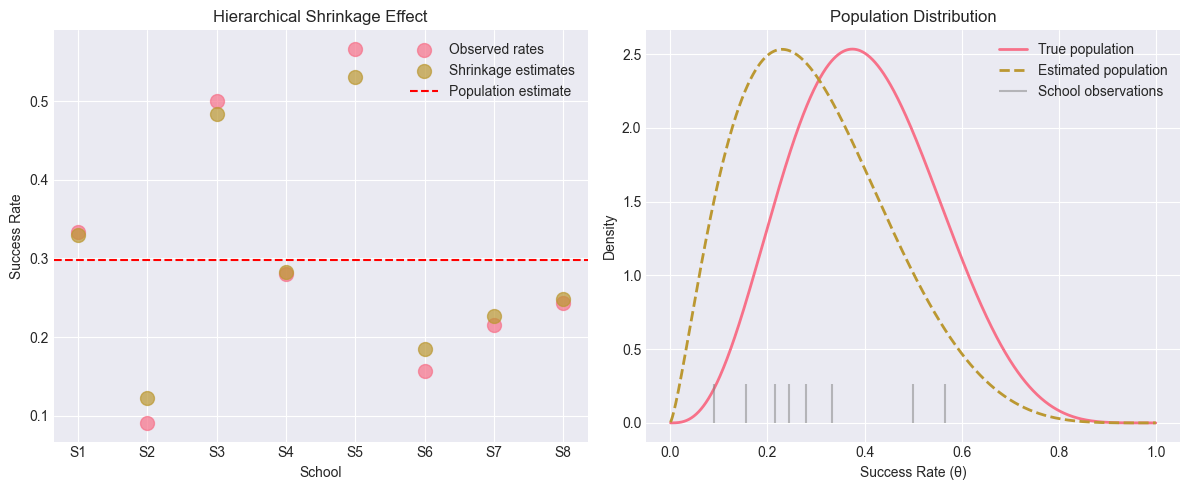


BETA-BINOMIAL REGRESSION MODEL
True regression coefficients:
  Intercept        -1.000
  Budget            0.500
  Middle Age        0.300
  Old Age          -0.200
  Weekend           0.400
  Budget×Weekend    0.200
  Dispersion (φ)    15.000

Estimated regression coefficients:
  Intercept         0.000
  Budget            0.000
  Middle Age        0.000
  Old Age           0.000
  Weekend           0.000
  Budget×Weekend    0.000
  Dispersion (φ)    10.000


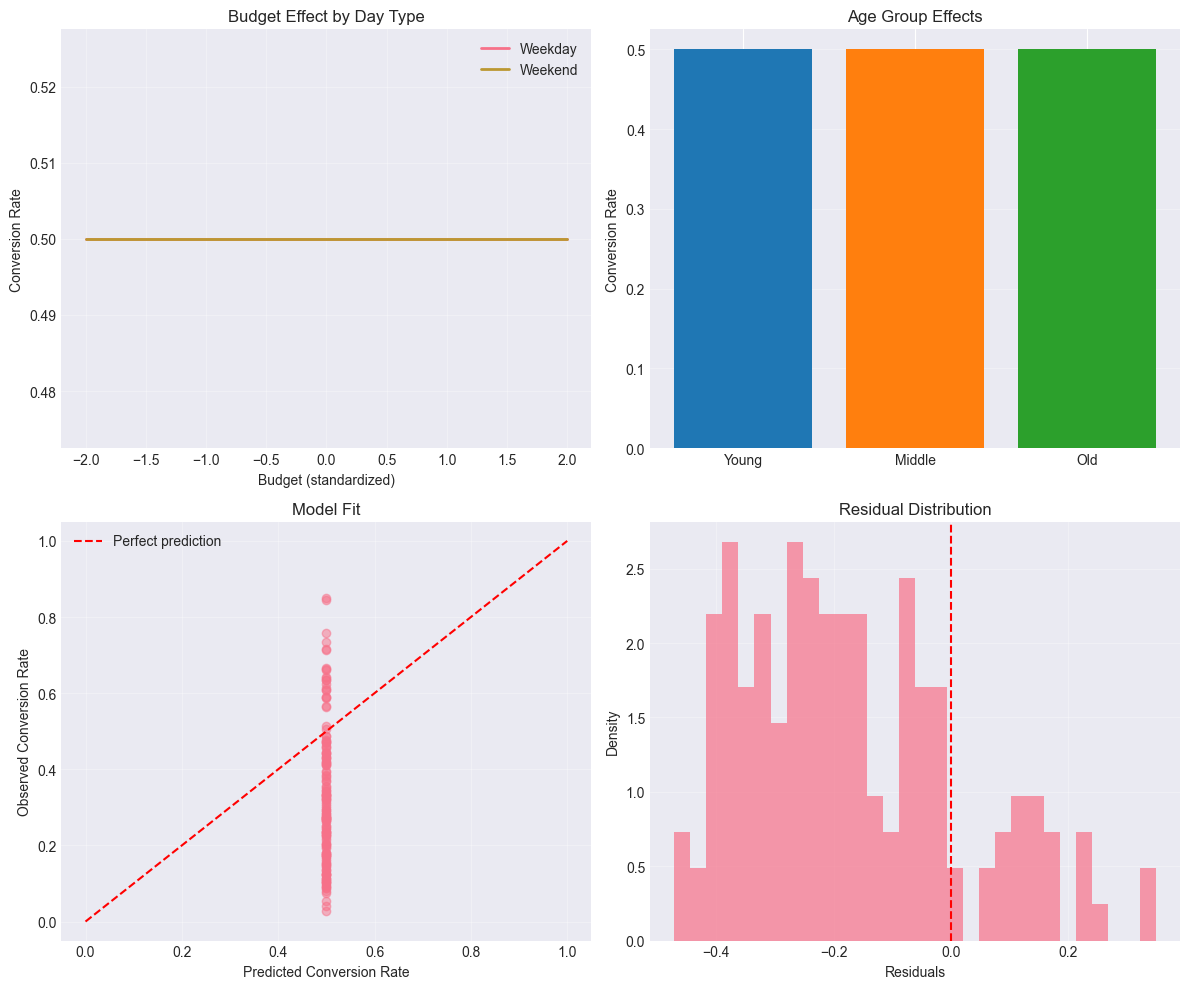


MIXTURE OF BETA-BINOMIAL MODEL
True segment parameters:
  Bargain Hunters: π=0.60, α=1.5, β=8.5, mean=0.150
  Quality Seekers: π=0.40, α=8.0, β=4.0, mean=0.667

Estimated segment parameters:
  Segment 1: π=0.40, α=0.6, β=1.1, mean=0.361
  Segment 2: π=0.60, α=0.6, β=1.1, mean=0.361


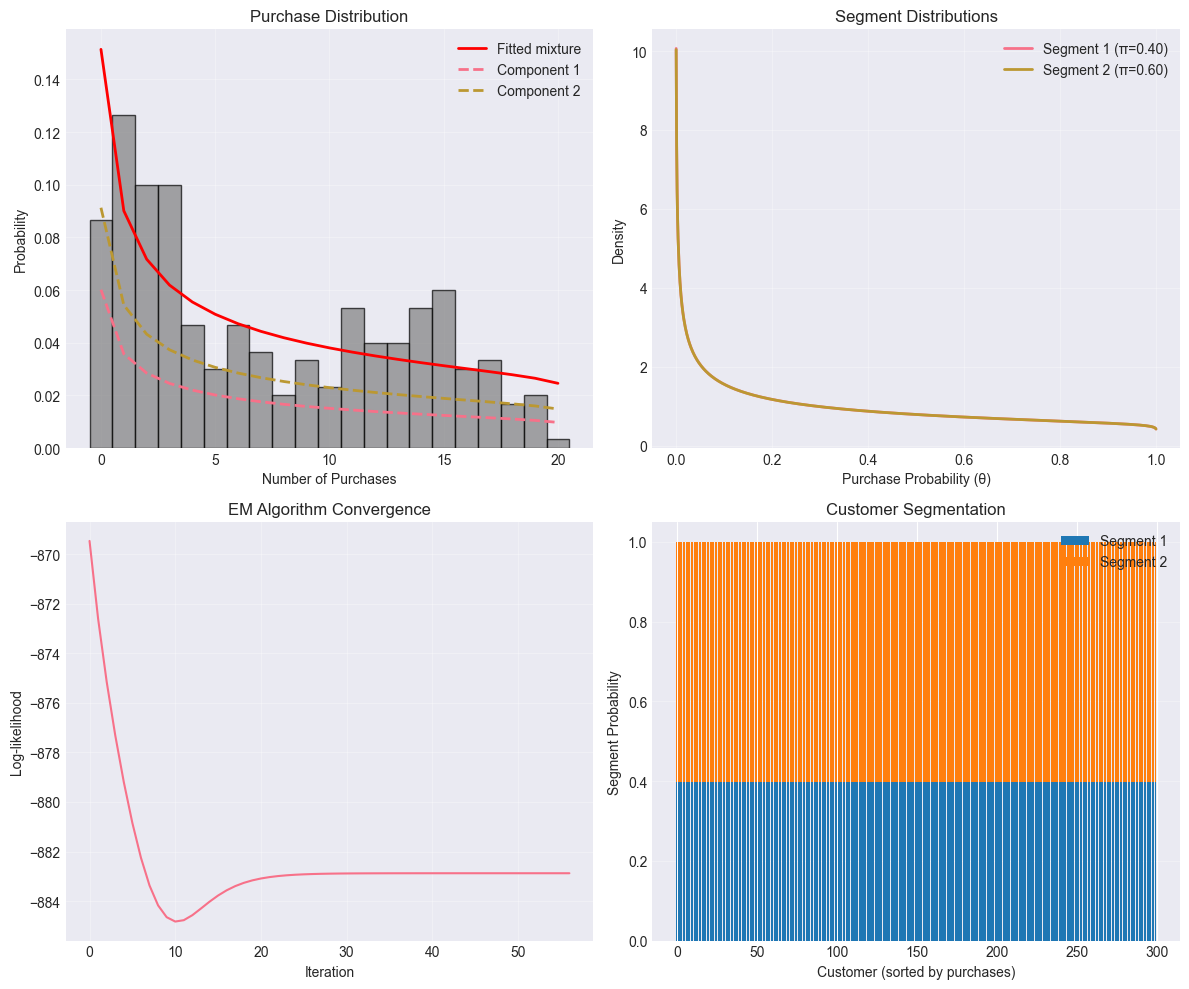


MODEL COMPARISON


ModuleNotFoundError: No module named 'complex_beta_binomial_models'

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================
# Example 1: Hierarchical Beta-Binomial
# ============================================
print("=" * 50)
print("HIERARCHICAL BETA-BINOMIAL MODEL")
print("=" * 50)

# Scenario: Multiple schools testing a new teaching method
# Each school has different number of students and success rates
np.random.seed(42)

# True population parameters
true_population_a = 4.0  # Population success parameter
true_population_b = 6.0  # Population failure parameter
population_mean = true_population_a / (true_population_a + true_population_b)

print(f"True population parameters: a={true_population_a}, b={true_population_b}")
print(f"Population mean success rate: {population_mean:.3f}")

# Generate data for 8 schools
n_schools = 8
school_sizes = np.random.randint(30, 100, n_schools)
school_names = [f"School {i+1}" for i in range(n_schools)]

# Each school has its own success rate drawn from population distribution
school_success_rates = np.random.beta(true_population_a, true_population_b, n_schools)
school_successes = []

for size, rate in zip(school_sizes, school_success_rates):
    successes = np.random.binomial(size, rate)
    school_successes.append(successes)

# Display school data
print("\nSchool Data:")
print(f"{'School':<10} {'Students':<10} {'Successes':<10} {'Rate':<10}")
print("-" * 40)
for i, (name, size, success, rate) in enumerate(
    zip(school_names, school_sizes, school_successes, school_success_rates)):
    obs_rate = success / size
    print(f"{name:<10} {size:<10} {success:<10} {obs_rate:<10.3f}")

# Fit hierarchical model
hier_model = HierarchicalBetaBinomial(alpha_a=2.0, beta_a=1.0, 
                                     alpha_b=2.0, beta_b=1.0)
a_est, b_est = hier_model.fit_map(school_sizes, school_successes)

print(f"\nEstimated population parameters: a={a_est:.3f}, b={b_est:.3f}")
print(f"Estimated population mean: {a_est/(a_est+b_est):.3f}")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: School-specific estimates vs hierarchical estimates
obs_rates = [s/n for s, n in zip(school_successes, school_sizes)]
school_indices = range(n_schools)

# Compute shrinkage estimates (posterior means for each school)
shrinkage_estimates = []
for i in range(n_schools):
    # Posterior for school i given population parameters
    post_a = a_est + school_successes[i]
    post_b = b_est + school_sizes[i] - school_successes[i]
    shrinkage_estimates.append(post_a / (post_a + post_b))

ax1.scatter(school_indices, obs_rates, s=100, alpha=0.7, label='Observed rates')
ax1.scatter(school_indices, shrinkage_estimates, s=100, alpha=0.7, label='Shrinkage estimates')
ax1.axhline(y=a_est/(a_est+b_est), color='red', linestyle='--', label='Population estimate')
ax1.set_xlabel('School')
ax1.set_ylabel('Success Rate')
ax1.set_title('Hierarchical Shrinkage Effect')
ax1.legend()
ax1.set_xticks(school_indices)
ax1.set_xticklabels([f"S{i+1}" for i in school_indices])

# Plot 2: Population distribution
theta_range = np.linspace(0.001, 0.999, 1000)
true_dist = stats.beta.pdf(theta_range, true_population_a, true_population_b)
est_dist = stats.beta.pdf(theta_range, a_est, b_est)

ax2.plot(theta_range, true_dist, label='True population', linewidth=2)
ax2.plot(theta_range, est_dist, label='Estimated population', linewidth=2, linestyle='--')
ax2.vlines(obs_rates, 0, ax2.get_ylim()[1]*0.1, colors='gray', alpha=0.5, label='School observations')
ax2.set_xlabel('Success Rate (θ)')
ax2.set_ylabel('Density')
ax2.set_title('Population Distribution')
ax2.legend()

plt.tight_layout()
plt.show()

# ============================================
# Example 2: Beta-Binomial Regression
# ============================================
print("\n" + "=" * 50)
print("BETA-BINOMIAL REGRESSION MODEL")
print("=" * 50)

# Scenario: Marketing campaign effectiveness with covariates
# Covariates: budget (standardized), target_age_group, is_weekend
np.random.seed(42)

n_campaigns = 150
n_customers = np.random.randint(100, 500, n_campaigns)

# Generate covariates
budget = np.random.normal(0, 1, n_campaigns)  # Standardized budget
age_group = np.random.choice([0, 1, 2], n_campaigns)  # Young, Middle, Old
is_weekend = np.random.choice([0, 1], n_campaigns)  # Weekday vs Weekend

# Create design matrix with interaction term
X = np.column_stack([
    np.ones(n_campaigns),         # Intercept
    budget,                       # Budget effect
    age_group == 1,              # Middle age indicator
    age_group == 2,              # Old age indicator  
    is_weekend,                  # Weekend indicator
    budget * is_weekend          # Budget-weekend interaction
])

# True parameters
true_beta = np.array([-1.0, 0.5, 0.3, -0.2, 0.4, 0.2])
true_phi = 15.0  # Dispersion parameter

print("True regression coefficients:")
coef_names = ['Intercept', 'Budget', 'Middle Age', 'Old Age', 'Weekend', 'Budget×Weekend']
for name, coef in zip(coef_names, true_beta):
    print(f"  {name:<15} {coef:>7.3f}")
print(f"  Dispersion (φ)   {true_phi:>7.3f}")

# Generate outcomes
mu = 1 / (1 + np.exp(-X @ true_beta))
conversions = []

for i in range(n_campaigns):
    a_i = mu[i] * true_phi
    b_i = (1 - mu[i]) * true_phi
    theta_i = np.random.beta(a_i, b_i)
    conversions.append(np.random.binomial(n_customers[i], theta_i))

# Fit regression model
reg_model = BetaBinomialRegression()
reg_model.fit(X, n_customers, conversions)

print("\nEstimated regression coefficients:")
for name, coef in zip(coef_names, reg_model.beta):
    print(f"  {name:<15} {coef:>7.3f}")
print(f"  Dispersion (φ)   {reg_model.phi:>7.3f}")

# Visualize effects
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Effect 1: Budget effect by weekend
budget_range = np.linspace(-2, 2, 100)

for weekend in [0, 1]:
    X_pred = np.column_stack([
        np.ones(100),
        budget_range,
        np.zeros(100),  # Middle age
        np.zeros(100),  # Old age
        np.full(100, weekend),
        budget_range * weekend
    ])
    
    mu_pred = reg_model.predict(X_pred)
    label = 'Weekend' if weekend else 'Weekday'
    axes[0, 0].plot(budget_range, mu_pred, label=label, linewidth=2)

axes[0, 0].set_xlabel('Budget (standardized)')
axes[0, 0].set_ylabel('Conversion Rate')
axes[0, 0].set_title('Budget Effect by Day Type')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Effect 2: Age group effect
age_labels = ['Young', 'Middle', 'Old']
age_effects = []

for age in range(3):
    X_pred = np.array([1, 0, age==1, age==2, 0, 0]).reshape(1, -1)
    mu_pred = reg_model.predict(X_pred)[0]
    age_effects.append(mu_pred)

axes[0, 1].bar(age_labels, age_effects, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0, 1].set_ylabel('Conversion Rate')
axes[0, 1].set_title('Age Group Effects')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Effect 3: Observed vs Predicted
obs_rates = np.array(conversions) / n_customers
pred_rates = reg_model.predict(X)

axes[1, 0].scatter(pred_rates, obs_rates, alpha=0.5)
axes[1, 0].plot([0, 1], [0, 1], 'r--', label='Perfect prediction')
axes[1, 0].set_xlabel('Predicted Conversion Rate')
axes[1, 0].set_ylabel('Observed Conversion Rate')
axes[1, 0].set_title('Model Fit')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Effect 4: Residual distribution
residuals = obs_rates - pred_rates
axes[1, 1].hist(residuals, bins=30, density=True, alpha=0.7)
axes[1, 1].axvline(x=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Residual Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# Example 3: Mixture of Beta-Binomials
# ============================================
print("\n" + "=" * 50)
print("MIXTURE OF BETA-BINOMIAL MODEL")
print("=" * 50)

# Scenario: Customer segments with different purchasing behaviors
# Two hidden segments: "bargain hunters" and "quality seekers"
np.random.seed(42)

n_customers_mix = 300
n_products_viewed = 20  # Each customer views 20 products

# True mixture parameters
segment_names = ['Bargain Hunters', 'Quality Seekers']
true_weights = [0.6, 0.4]  # 60% bargain hunters, 40% quality seekers
true_alphas = [1.5, 8.0]   # Bargain hunters have lower, more variable purchase rate
true_betas = [8.5, 4.0]    # Quality seekers have higher, more consistent rate

print("True segment parameters:")
for i, name in enumerate(segment_names):
    mean_rate = true_alphas[i] / (true_alphas[i] + true_betas[i])
    print(f"  {name}: π={true_weights[i]:.2f}, α={true_alphas[i]:.1f}, "
          f"β={true_betas[i]:.1f}, mean={mean_rate:.3f}")

# Generate data
segment_assignments = np.random.choice(2, n_customers_mix, p=true_weights)
purchases = []

for i in range(n_customers_mix):
    segment = segment_assignments[i]
    theta = np.random.beta(true_alphas[segment], true_betas[segment])
    n_purchases = np.random.binomial(n_products_viewed, theta)
    purchases.append(n_purchases)

purchases = np.array(purchases)

# Fit mixture model
mix_model = MixtureBetaBinomial(n_components=2)
mix_model, log_likelihoods = mix_model.fit(
    [n_products_viewed] * n_customers_mix, purchases, max_iter=100)

print("\nEstimated segment parameters:")
# Sort components by mean for consistent ordering
est_means = [mix_model.alphas[k]/(mix_model.alphas[k]+mix_model.betas[k]) 
             for k in range(2)]
sorted_idx = np.argsort(est_means)

for idx, k in enumerate(sorted_idx):
    mean_rate = mix_model.alphas[k] / (mix_model.alphas[k] + mix_model.betas[k])
    print(f"  Segment {idx+1}: π={mix_model.weights[k]:.2f}, "
          f"α={mix_model.alphas[k]:.1f}, β={mix_model.betas[k]:.1f}, "
          f"mean={mean_rate:.3f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Histogram of purchases with mixture fit
axes[0, 0].hist(purchases, bins=np.arange(n_products_viewed+2)-0.5, 
                density=True, alpha=0.7, color='gray', edgecolor='black')

# Overlay mixture PMF
x_range = np.arange(n_products_viewed + 1)
mixture_pmf = mix_model.predict_distribution(n_products_viewed)
axes[0, 0].plot(x_range, mixture_pmf, 'r-', linewidth=2, 
                label='Fitted mixture')

# Overlay component PMFs
for k in range(2):
    component_pmf = stats.betabinom.pmf(
        x_range, n_products_viewed, 
        mix_model.alphas[k], mix_model.betas[k])
    axes[0, 0].plot(x_range, mix_model.weights[k] * component_pmf, 
                    '--', linewidth=2, label=f'Component {k+1}')

axes[0, 0].set_xlabel('Number of Purchases')
axes[0, 0].set_ylabel('Probability')
axes[0, 0].set_title('Purchase Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Component Beta distributions
theta_range = np.linspace(0.001, 0.999, 1000)

for k in range(2):
    density = stats.beta.pdf(theta_range, 
                           mix_model.alphas[k], 
                           mix_model.betas[k])
    axes[0, 1].plot(theta_range, density, linewidth=2,
                    label=f'Segment {k+1} (π={mix_model.weights[k]:.2f})')

axes[0, 1].set_xlabel('Purchase Probability (θ)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Segment Distributions')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Convergence
axes[1, 0].plot(log_likelihoods)
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Log-likelihood')
axes[1, 0].set_title('EM Algorithm Convergence')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Customer segmentation
responsibilities = mix_model.predict_proba(
    [n_products_viewed] * n_customers_mix, purchases)

# Sort customers by purchase count for visualization
sort_idx = np.argsort(purchases)
sorted_purchases = purchases[sort_idx]
sorted_responsibilities = responsibilities[sort_idx, :]

# Create stacked bar chart
bottom = np.zeros(len(sorted_purchases))
colors = ['#1f77b4', '#ff7f0e']

for k in range(2):
    axes[1, 1].bar(range(len(sorted_purchases)), 
                   sorted_responsibilities[:, k],
                   bottom=bottom, color=colors[k], 
                   label=f'Segment {k+1}')
    bottom += sorted_responsibilities[:, k]

axes[1, 1].set_xlabel('Customer (sorted by purchases)')
axes[1, 1].set_ylabel('Segment Probability')
axes[1, 1].set_title('Customer Segmentation')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================
# Model Comparison
# ============================================
print("\n" + "=" * 50)
print("MODEL COMPARISON")
print("=" * 50)

# Compare simple Beta-Binomial vs Mixture on the mixture data
from complex_beta_binomial_models import BetaBinomialModel

# Fit simple Beta-Binomial
simple_model = BetaBinomialModel()
n_array = [n_products_viewed] * n_customers_mix

# Calculate MLE parameters using method of moments
p_hat = purchases / n_products_viewed
mean_p = np.mean(p_hat)
var_p = np.var(p_hat)

if var_p < mean_p * (1 - mean_p):
    common = mean_p * (1 - mean_p) / var_p - 1
    simple_a = mean_p * common
    simple_b = (1 - mean_p) * common
else:
    simple_a = 1.0
    simple_b = 1.0

# Compare log-likelihoods
simple_log_lik = 0
for i in range(n_customers_mix):
    simple_log_lik += np.log(stats.betabinom.pmf(
        purchases[i], n_products_viewed, simple_a, simple_b))

mixture_log_lik = mix_model.log_likelihood(n_array, purchases)

# AIC and BIC
n_params_simple = 2  # a and b
n_params_mixture = 5  # 2 weights (1 free), 2 alphas, 2 betas

aic_simple = 2 * n_params_simple - 2 * simple_log_lik
aic_mixture = 2 * n_params_mixture - 2 * mixture_log_lik

bic_simple = n_params_simple * np.log(n_customers_mix) - 2 * simple_log_lik
bic_mixture = n_params_mixture * np.log(n_customers_mix) - 2 * mixture_log_lik

print("Model comparison (lower is better):")
print(f"Simple Beta-Binomial:  AIC={aic_simple:.1f}, BIC={bic_simple:.1f}")
print(f"Mixture (2 components): AIC={aic_mixture:.1f}, BIC={bic_mixture:.1f}")
print(f"\nPreferred model: {'Mixture' if aic_mixture < aic_simple else 'Simple'}")

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Data histogram
ax.hist(purchases, bins=np.arange(n_products_viewed+2)-0.5, 
        density=True, alpha=0.7, color='gray', edgecolor='black',
        label='Data')

# Simple model fit
x_range = np.arange(n_products_viewed + 1)
simple_pmf = stats.betabinom.pmf(x_range, n_products_viewed, simple_a, simple_b)
ax.plot(x_range, simple_pmf, 'b-', linewidth=2, 
        label=f'Simple (AIC={aic_simple:.0f})')

# Mixture model fit
mixture_pmf = mix_model.predict_distribution(n_products_viewed)
ax.plot(x_range, mixture_pmf, 'r-', linewidth=2, 
        label=f'Mixture (AIC={aic_mixture:.0f})')

ax.set_xlabel('Number of Purchases')
ax.set_ylabel('Probability')
ax.set_title('Model Comparison: Simple vs Mixture')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()